In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

UNCLASSIFIED = False
NOISE = -1

# Task - Density‐based Clustering

### _dist()函數用來回傳兩點間距離

In [2]:
def _dist(p,q):
    # compute and return the euclidean distance
    # put your code here
    dis=math.sqrt(np.power(p-q,2).sum())
    return dis

###  _eps_neighborhood()函數判斷距離大於eps回傳True，距離小於eps回傳False

In [3]:
def _eps_neighborhood(p,q,eps):
    # check if the distance between p and q is below eps
    # return True or False
    # put your code here
    dis=_dist(p,q) 
    if (dis<eps):
        return "True"
    else:
        return "False"

### _region_query()函數將以point_id為中心，eps為半徑畫一個圓，回傳除了中心點以外在此圓內的所有其他點

In [4]:
def _region_query(m, point_id, eps):
    n_points = m.shape[1]
    seeds = []
    # find and return all points that belong to eps-neighborhood of point_id
    # put your code here
    for i in range(n_points):
        
        # 運用pandas，m[:,point_id]可以直接從m當中提取出point_id的座標，在使用迴圈與m內的所有其他點做比對，假如_eps_neighborhood()
        #回傳為True，就把該點放入seeds的list當中
        if (_eps_neighborhood(m[:,point_id],m[:,i],eps)=='True'):
            seeds.append(i)
    return seeds

### 這裡我使用的方法是，先以point_id的點開始不斷向外擴充，把每一次擴張的點都納入名為All_point的list，並且不斷的對此list進行set的動作把重複的點給刪除，直到All_point裡面的要素數量不再改變，就停止擴張。

### 接下來要開始處理classifications，All_point裡的點可以藉由判斷該點的seeds數量來先判斷屬於Noise還是Core。而比較難處理的是Border，Border沒辦法直接用seeds的數量去判斷，需要另外去判別到底是屬於哪一群，而我使用的方法是，先去了解該點所有的neighbor分別是屬於哪一群的，在看看屬於哪一群的點是最多的，這樣就知道該點是屬於哪一群的Border。

In [5]:
num=[]
def _expand_cluster(m, classifications, point_id, cluster_id, eps, min_points,num):
    # expand the cluster of cluster_id from point_id
    # identify all points belonging to cluster_id
    # update the clustering results in "classification" by assigning cluster_id to each point
    # return True if point_id is a core, False if point_id is not a core
    # write your code below
    
    seeds=_region_query(m, point_id, eps)
    # 該點的seeds數量小於min_points代表屬於Noise，回傳False
    if (len(seeds)<min_points):
        classifications[point_id]=NOISE
        return False
    # 從point_id的點開始不斷向外擴充，把每一次擴張的點都納入名為All_point的list
    else:
        classifications[point_id] = cluster_id
        All_point=[]
        while (True):            
            for i in range(len(seeds)):
                seeds_result=_region_query(m, seeds[i], eps)
                if (len(seeds_result)>=min_points):
                    for j in range(len(seeds_result)):
                        seeds_result2=_region_query(m, seeds_result[j], eps)
                        if (len(seeds_result2)>=min_points):
                            for k in range(len(seeds_result2)):
                                All_point.append(seeds_result2[k])
            N=len(seeds)
             # 對All_point進行set的動作把重複的點給刪除，直到All_point裡面的要素數量不再改變，即可跳出While迴圈
            seeds=list(set(All_point))
            if (N==len(seeds)):
                break
        # 這裡開始針對All_point的點進行分類，看是屬於Core、Border、Noise哪一個，並寫入classifications中
        N2=[]
        for i in range(len(seeds)):
            seeds_result=_region_query(m, seeds[i], eps)
            if (len(seeds_result)>=min_points):
                classifications[seeds[i]]=cluster_id
            else: 
                # 該點的seeds數量為0，代表是屬於Noise
                if (len(seeds_result)==0): 
                    classifications[seeds[i]]=NOISE
                # 此處去找出該點所有neighbor分別是屬於哪一群的，在看看屬於哪一群的點是最多的，這樣就知道該點是屬於哪一群的Border
                else:
                    num2=num
                    num=[]
                    for k in range(len(seeds_result)):
                        for j in range(len(seeds)):
                            if (seeds_result[k]==seeds[j]):
                                num.append(seeds[i])
                            if (len(num)>len(num2)):
                                classifications[seeds[i]]=cluster_id
                                break
                    if (classifications[seeds[i]]==False):
                        classifications[seeds[i]]=cluster_id
        return True

### 這邊要去重複執行_expand_cluster()，把分類的結果寫進classifications。_expand_cluster()跑完一次代表分類出了一群，因此第二次之後cluster_id加上1，就能在classifications裡面清楚作分類。

In [6]:
def dbscan(m, eps, min_points):
    """Implementation of DBSCAN
    You can refer to wikipedia for detailed algorithm: https://en.wikipedia.org/wiki/DBSCAN
    Use Euclidean Distance as the measure
    
    Inputs:
    m - A matrix whose columns are feature vectors
    eps - Maximum distance two points can be to be regionally related
    min_points - The minimum number of points to make a cluster
    
    Outputs:
    An array with either a cluster id number or dbscan.NOISE (None) for each column vector in m
    """
    cluster_id = 1
    n_points = m.shape[1]
    classifications = [UNCLASSIFIED] * n_points
    # the main dbscan algorithm
    # put your code here
    num1=[]
    for i in range(n_points):
        # 只有在該點為UNCLASSIFIED的時候需要跑_expand_cluster()，避免重複去分類同一群
        if (classifications[i]==UNCLASSIFIED):
            r=_expand_cluster(m, classifications, i, cluster_id, eps, min_points,num)
            # Noise的時候值為-1，因此不需要做cluster_id加上1的動作
            if (r!=False):
                cluster_id=cluster_id+1
    return classifications

# 測試一

In [7]:
# test here
dataset_1 = pd.read_csv('blobs.csv')[:80].values
m = np.asmatrix(dataset_1)
m = m.transpose()

In [8]:
eps = 1.6
min_points = 5
a = dbscan(m, eps, min_points)

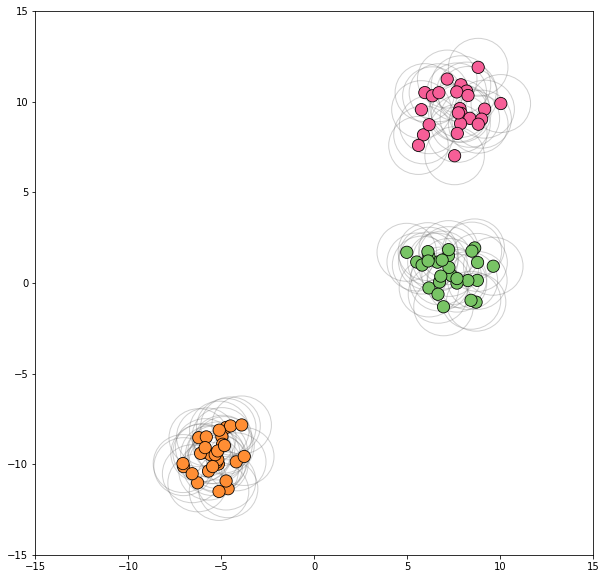

In [9]:
%matplotlib inline
import dbscan_lab_helper as helper

result = np.asarray(a)
helper.plot_clustered_dataset(dataset_1, result, neighborhood=True, epsilon=eps)

# 測試二 (大約需要跑兩分半的時間)

### 由於我在_expand_cluster()的部分使用了太多層迴圈，大幅增加運算量，導致需要花很大的時間成本。演算法上還有很大的改進空間才對。

In [10]:
dataset_2 = pd.read_csv('varied.csv')[:300].values
m = np.asmatrix(dataset_2)
m = m.transpose()

In [11]:
eps = 1.3
min_points = 5
a = dbscan(m, eps, min_points)

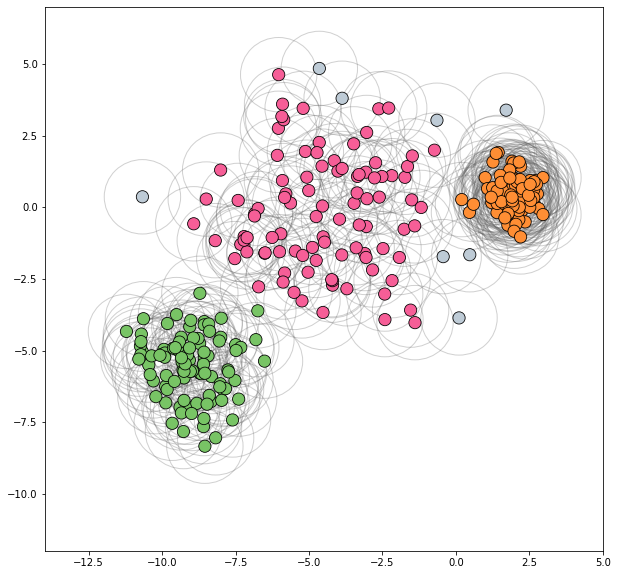

In [12]:
result = np.asarray(a)
helper.plot_clustered_dataset(dataset_2, result, xlim=(-14, 5), ylim=(-12, 7), neighborhood=True, epsilon=eps)
